# VC data exploration 

in this exercise we will deep dive into a dataset of products that were live on the VC website 

### import packages and read the data 

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy
import scipy.stats
import time

from sklearn.model_selection import train_test_split

%matplotlib inline 

In [36]:
data_init = pd.read_csv("../data/ex3_product_data.csv")

In [37]:
data_prod = data_init.copy()

let's see what the data look like from up close 

In [38]:
data_prod.head()

,category,sub_category,brand,model,material,color,quality,flag,pop1,pop2,time_online,sold,price
0,2.0,21.0,63.0,NaN,8.0,4.0,2.0,1,6,64,10,1,2434.14
1,2.0,9.0,377.0,NaN,66.0,15.0,2.0,0,0,28,7,1,1833.54
2,2.0,21.0,499.0,NaN,66.0,15.0,2.0,0,2,42,5,1,2581.95
3,2.0,45.0,499.0,NaN,25.0,21.0,2.0,0,5,19,429,0,2048.04
4,2.0,42.0,541.0,NaN,8.0,24.0,2.0,0,5,55,96,1,789.64


In [39]:
data_prod.isnull().sum() / data_prod.shape[0] * 100

category         0.000000
sub_category     0.000000
brand            0.000000
model           94.927348
material         0.004093
color            0.017737
quality          0.000000
flag             0.000000
pop1             0.000000
pop2             0.000000
time_online      0.000000
sold             0.000000
price            0.000000
dtype: float64

There are a lot of missing values ont the model feature (94%)

In [7]:
data_prod.describe()

,category,sub_category,brand,model,material,color,quality,flag,pop1,pop2,time_online,sold,price
count,73295.000000,73295.000000,73295.000000,3718.000000,73292.000000,73282.000000,73295.000000,73295.000000,73295.000000,73295.000000,73295.000000,73295.000000,73295.000000
mean,2.292162,26.686227,570.127676,93.183701,33.796785,10.051431,1.760106,0.035350,7.220111,67.683907,253.693294,0.630275,2405.763657
std,1.116533,17.198274,303.366991,59.364466,20.249989,7.461880,0.465190,0.184665,8.702356,66.908734,245.221178,0.482733,2909.506660
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,225.210000
25%,2.000000,11.000000,315.000000,38.000000,20.000000,3.000000,2.000000,0.000000,2.000000,28.000000,18.000000,0.000000,1075.640000
50%,2.000000,21.000000,541.000000,81.000000,28.000000,8.000000,2.000000,0.000000,5.000000,48.000000,154.000000,1.000000,1719.140000
75%,3.000000,44.000000,852.000000,149.000000,55.000000,16.000000,2.000000,0.000000,9.000000,83.000000,477.000000,1.000000,2795.510000
max,4.000000,58.000000,1099.000000,216.000000,68.000000,25.000000,2.000000,1.000000,212.000000,1374.000000,728.000000,1.000000,243103.140000


<Figure size 1152x576 with 0 Axes>

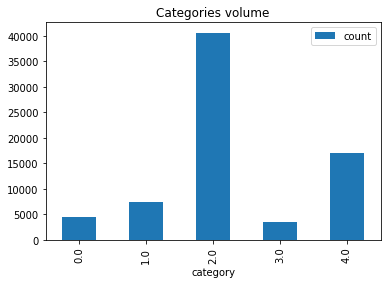

In [8]:
categ = data_prod.groupby("category").agg({"price":"count"}).reset_index()
categ.columns = ["category","count"]

plt.figure(figsize=(16,8))
categ.plot.bar(x="category", y="count")
plt.title("Categories volume")
plt.show()

In [9]:
categ

,category,count
0,0.0,4508
1,1.0,7445
2,2.0,40605
3,3.0,3599
4,4.0,17138


In [10]:
data_prod.groupby("sold").sold.count()

sold
0    27099
1    46196
Name: sold, dtype: int64

### Distribution of the time to sell

Before plotting the distribution, we will first see when the products are mostly sold in terms of quantity and in terms of price 

In [11]:
analysis = (data_prod[data_prod["sold"] == 1].groupby("time_online")
                                             .agg({"category":"count", "price":"sum"})
                                             .sort_values("category", ascending=False)
                                             .reset_index()
                                             .head(10))

analysis["mean_price"] = analysis["price"] / analysis["category"]

analysis

,time_online,category,price,mean_price
0,1,2982,8295020.05,2781.696865
1,0,2276,6178483.46,2714.623664
2,2,1748,4554090.81,2605.315109
3,3,1498,3717933.63,2481.931662
4,4,1240,3000876.87,2420.061992
5,5,1055,2465137.72,2336.623431
6,6,958,2385338.53,2489.914958
7,7,870,2151786.79,2473.318149
8,8,836,2083218.33,2491.887955
9,9,752,1863069.35,2477.485838


In order to plot the distribution of the time to sell, we need to remove the noise and focus on only the product that have been sold 

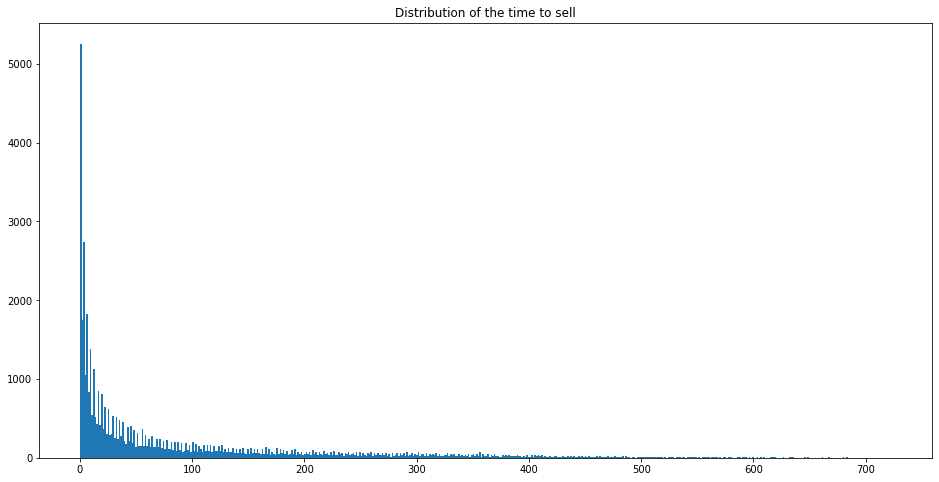

In [12]:
data_to_hist = data_prod[data_prod["sold"] == 1]["time_online"]

bins=500

y, x = np.histogram(data_to_hist, bins=bins, density=True)

plt.figure(figsize=(16,8))
plt.hist(data_to_hist, bins=500)
plt.title("Distribution of the time to sell")
plt.show()

We can notice that most of the products are sold on the first days. Now let's fit an appropriate distribution using scipy and by testing many distribution and selecting the best one 


In [13]:
class Apropriate_dist():
    def __init__(self, best_dist):
        self.name = best_dist[4]
        self.pdf = best_dist[0]
        self.loc = best_dist[1]
        self.scale = best_dist[2]
        self.arg = best_dist[3]
        self.x = best_dist[5]
        self.y = best_dist[6]

def fit_appropriate_dist(data, bins=1000):
    dist_names = ['gamma', 'pareto', 't', 'lognorm', 'invgamma', 'invgauss',  'loggamma', 'alpha', 'chi', 'chi2']

    sse = np.inf
    sse_thr = 0.10
    
    y, x = np.histogram(data_to_hist, bins=bins, density=True)
    
    x = x[1:]
    # for each distribution
    for name in dist_names:
        # modelize
        dist = getattr(scipy.stats, name)
        param = dist.fit(data)

        # parameters
        loc = param[-2] # mean
        scale = param[-1] # std
        arg = param[:-2]

        # PDF
        pdf = dist.pdf(x, *arg, loc=loc, scale=scale)

        # SSE
        model_sse = np.sum((y - pdf)**2)
        
        # if the SSE decrease, save the model 
        if model_sse < sse :
            best_pdf = pdf
            sse = model_sse
            best_loc = loc
            best_scale = scale
            best_arg = arg
            best_name = name

        # if below threshold, break !
        if model_sse < sse_thr :
            return [best_pdf, best_loc, best_scale, best_arg, best_name, x, y]

In [14]:
best_dist = Apropriate_dist(fit_appropriate_dist(data_to_hist))

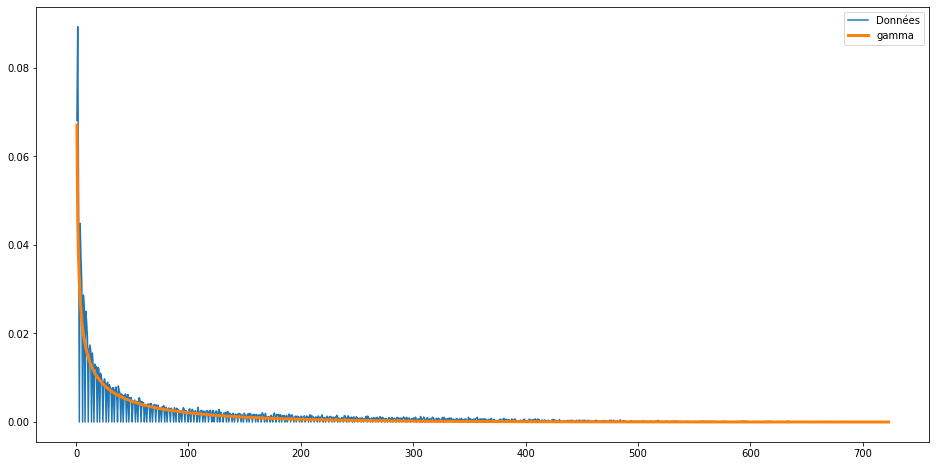

Selected Model :  gamma
Loc. param. :  -3.284604203569409e-29
Scale param. :  116.66799188922289
Other arguments :  (0.46930069453591816,)


In [15]:
plt.figure(figsize=(16,8))
plt.plot(best_dist.x, best_dist.y, label="Données")
plt.plot(best_dist.x, best_dist.pdf, label=best_dist.name, linewidth=3)
plt.legend(loc='upper right')
plt.show()

# some details about the selected distribution law
print("Selected Model : ", best_dist.name)
print("Loc. param. : ", best_dist.loc)
print("Scale param. : ", best_dist.scale)
print("Other arguments : ", best_dist.arg)
# print("SSE : ", sse)

The best distribution law for the time to sell variable is the gamma law 

### Sell rate at 30 days 

The sell rate is the amount of product sold on the total amount of products. In our case, we need to create a column "sold in 30 days" in order to diferentiate the different products

In [40]:
data_prod["sold_in_30_days"] = data_prod.apply(lambda x: True if x["sold"] == 1 and x["time_online"]<=30 else False, axis=1)

In [41]:
anaylse_sell_rate = data_prod.groupby(["category","sold_in_30_days"]).brand.count().reset_index()

In [42]:
anaylse_sell_rate = pd.pivot_table(anaylse_sell_rate, values='brand', index=["category"], columns=["sold_in_30_days"], aggfunc=np.sum).reset_index()
anaylse_sell_rate["sell_rate"] = anaylse_sell_rate[True] / (anaylse_sell_rate[False] + anaylse_sell_rate[True]) * 100

anaylse_sell_rate.sort_values("sell_rate", ascending=False)

sold_in_30_days,category,False,True,sell_rate
3,3.0,2155,1444,40.122256
1,1.0,4547,2898,38.925453
0,0.0,3035,1473,32.675244
4,4.0,12142,4996,29.151593
2,2.0,28815,11790,29.035833


We notice that the category that has the most seeling rate is the 3rd category with 40% of the products sold within 30 days 

In [43]:
data_prod[data_prod["time_online"] < 30].groupby(["category","sold"]).brand.count().reset_index()

,category,sold,brand
0,0.0,1,1459
1,1.0,1,2863
2,2.0,1,11663
3,3.0,1,1421
4,4.0,1,4945


### The 5 most  expensive brands

In [44]:
data_prod.groupby("brand").agg({"price":"mean"}).sort_values("price", ascending=False).head(5)

,price
brand,
642.0,75793.140
587.0,65894.170
747.0,51483.140
864.0,41915.725
929.0,34323.140


The 642 is way too expensive !! it must be **GUCCI** 

In [45]:
data_prod.groupby("sold").agg({"category":"count", "time_online":"max"})

,category,time_online
sold,,
0,27099,728
1,46196,723


### Price estimation 

Before beginning to clean our data let's have a look at our price distribution

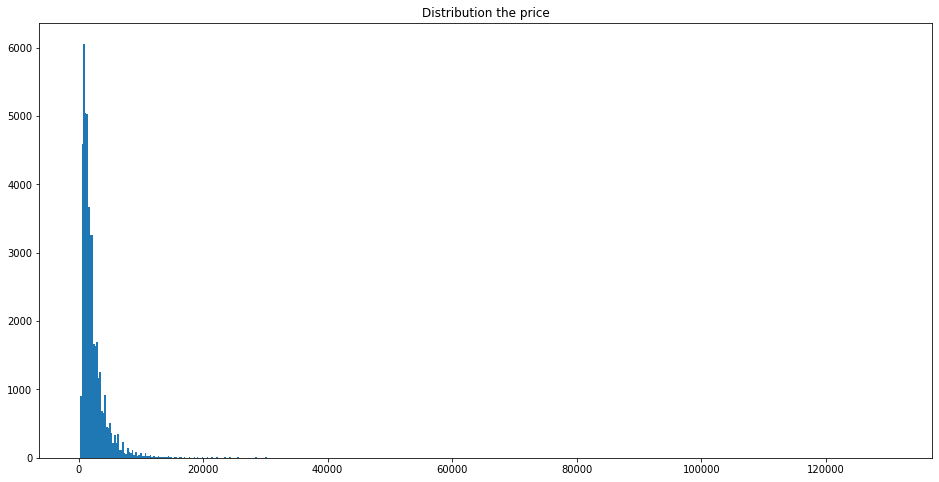

In [46]:
data_price = data_prod[data_prod["sold"] == 1]["price"]

plt.figure(figsize=(16,8))
plt.hist(data_price, bins=500)
plt.title("Distribution the price")
plt.show()

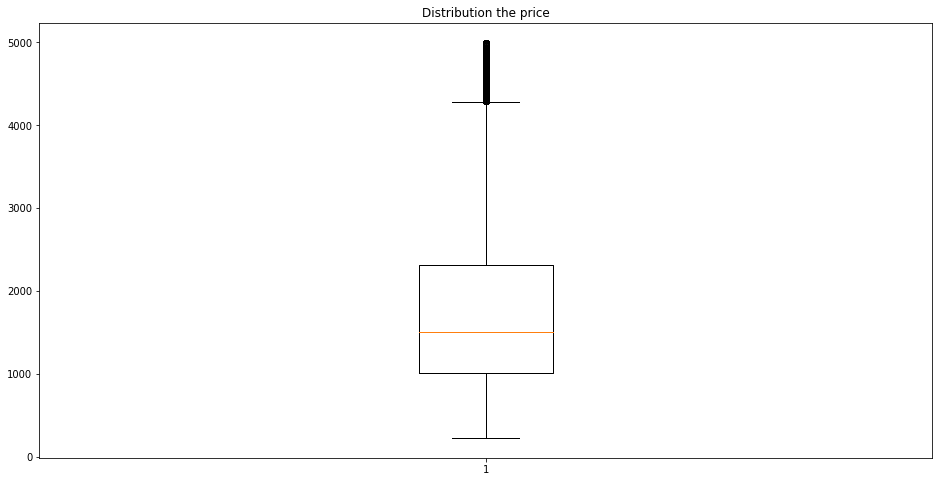

In [47]:
plt.figure(figsize=(16,8))
plt.boxplot(data_price[data_price<5000])
plt.title("Distribution the price")
plt.show()

In [48]:
for i in range(0, 100, 10):
    var = data_price
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 225.21
10 percentile value is 718.14
20 percentile value is 932.64
30 percentile value is 1147.14
40 percentile value is 1361.64
50 percentile value is 1618.54
60 percentile value is 1998.67
70 percentile value is 2418.87
80 percentile value is 3149.14
90 percentile value is 4473.49
100 percentile value is  130540.12


In [25]:
data_price[data_price < 5000].shape[0] / data_price.shape[0]

0.9181963806390163

91% of the products that have been sold have a price lower thant 5k. In order to develop a model capable to estimate the selling price we will need to focus on the product that have been sold and remove the outliers.

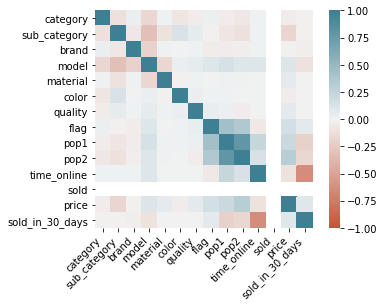

In [49]:
import seaborn as sns

data_sold = data_prod[data_prod["sold"] == 1]

corr = data_sold.corr()

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

We notice the strong correlation between pop1 and pop2 which both calculate the popularity oh a certain product

In [50]:
brand_mean_price = data_sold.groupby("brand").agg({"price":"mean"}).reset_index()
brand_mean_price.columns = ["brand","brand_mean_price"]
data_sold = data_sold.merge(brand_mean_price, on="brand", how="left")



<AxesSubplot:xlabel='brand_mean_price', ylabel='price'>

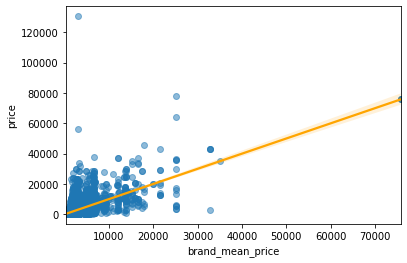

In [53]:
sns.regplot(x="brand_mean_price", y="price", data=data_sold,
            scatter_kws={"alpha":0.5}, line_kws={"color":"orange"})

In [54]:
data_sold[data_sold["price"]>130000]

,category,sub_category,brand,model,material,color,quality,flag,pop1,pop2,time_online,sold,price,sold_in_30_days,brand_mean_price
11082,2.0,11.0,47.0,NaN,47.0,12.0,2.0,0,21,391,26,1,130540.12,True,3084.305849


#### cleaning of the data

In [120]:
def clean_data(data_prod):
    
    data_prod["sold_in_30_days"] = data_prod.apply(lambda x: True if x["sold"] == 1 and x["time_online"]<=30 else False, axis=1)
    
    anaylse_sell_rate = data_prod.groupby(["category","sold_in_30_days"]).brand.count().reset_index()
    anaylse_sell_rate = pd.pivot_table(anaylse_sell_rate, values='brand', index=["category"], columns=["sold_in_30_days"], aggfunc=np.sum).reset_index()
    anaylse_sell_rate["sell_rate"] = anaylse_sell_rate[True] / (anaylse_sell_rate[False] + anaylse_sell_rate[True]) * 100
    
    anaylse_sell_rate = anaylse_sell_rate[["category","sell_rate"]]
    
    data_prod = data_prod.merge(anaylse_sell_rate, on="category", how="left")
    
    # select data sold
    data_sold = data_prod[data_prod["sold"] == 1]

    # remove model feature since 93% of missing values
    data_sold = data_sold.drop("model", axis=1)

    # fillna for color and material 
    data_sold["color"] = data_sold.color.fillna(-1)
    data_sold["material"] = data_sold.material.fillna(-1)
    
    #remove the outliers 
    data_sold = data_sold[data_sold.price < 10000]
    
    brand_mean_price = data_sold.groupby("brand").agg({"price":"mean"}).reset_index()
    brand_mean_price.columns = ["brand","brand_mean_price"]
    data_sold = data_sold.merge(brand_mean_price, on="brand", how="left")
    

    return data_sold

In [121]:
def normalize(df, cols_to_normalize):
    result = df.copy()
    for feature_name in df.columns:
        if (feature_name in cols_to_normalize):
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    
    return result

def feature_engineering(data_sold):
    categorical_feature = ["category","sub_category","brand","material","color","quality","sold_in_30_days"]
    continuous_feature = ["pop1", "pop2","price","sell_rate","brand_mean_price"]
    colums = categorical_feature + continuous_feature
    data_sold = data_sold[colums]

    for categ in categorical_feature:
        data_sold[categ] = data_sold[categ].astype(int)

    for conti in continuous_feature:
        data_sold[conti] = data_sold[conti].astype(float)

    cols_to_normalise = continuous_feature.copy()
    cols_to_normalise.remove("price")
    data_sold = normalize(data_sold, cols_to_normalise)
    
    return data_sold

In [122]:
data_sold = clean_data(data_init)
data_sold = feature_engineering(data_sold)

C:\Users\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [123]:
data_sold.isnull().sum() / data_sold.shape[0] * 100

category            0.0
sub_category        0.0
brand               0.0
material            0.0
color               0.0
quality             0.0
sold_in_30_days     0.0
pop1                0.0
pop2                0.0
price               0.0
sell_rate           0.0
brand_mean_price    0.0
dtype: float64

In [125]:
data_sold.shape

(45547, 12)

#### train test split 

Before splitting we'll need to convert the target variable to logarithmic scale in order to use root mean square error as the metric instead of explicitly defining a complex metric RMSLE (RMSLE is nothing but RMSE of log values)

In [126]:
y = np.log1p(data_sold["price"])
X = data_sold.drop("price", axis=1)

X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print('Train size: {}, Test size: {}' .format(X_train.shape, X_test.shape))


Train size: (40992, 11), Test size: (4555, 11)


#### SVR

C:\Users\ASUS\AppData\Roaming\Python\Python36\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Train RMSLE: 0.7167664256594026
Cross validation RMSLE:  0.723155834619282


C:\Users\ASUS\AppData\Roaming\Python\Python36\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Train RMSLE: 0.7167592137664632
Cross validation RMSLE:  0.7231579863353922


C:\Users\ASUS\AppData\Roaming\Python\Python36\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Train RMSLE: 0.7168511614898568
Cross validation RMSLE:  0.7233160772024511


C:\Users\ASUS\AppData\Roaming\Python\Python36\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Train RMSLE: 0.7169466109932763
Cross validation RMSLE:  0.7234729076714559


C:\Users\ASUS\AppData\Roaming\Python\Python36\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Train RMSLE: 0.717389836984215
Cross validation RMSLE:  0.7241017203734862


C:\Users\ASUS\AppData\Roaming\Python\Python36\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Train RMSLE: 0.71797216921611
Cross validation RMSLE:  0.724764133512414


C:\Users\ASUS\AppData\Roaming\Python\Python36\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Train RMSLE: 0.7196564925780399
Cross validation RMSLE:  0.7267412090751193


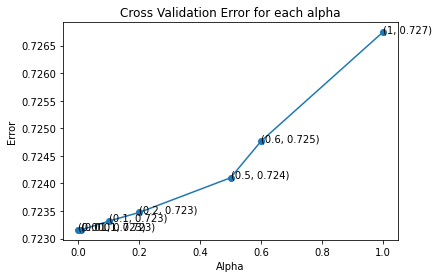

In [99]:
from sklearn.svm import SVR
from math import sqrt 
from sklearn.metrics import mean_squared_error as mse

c = [0.0001, 0.01, 0.1, 0.2, 0.5, 0.6, 1] 
cv_rmsle_array=[] 

for i in c:    
    # print('Best C: ', best_C)
    model = SVR(C=i, max_iter=200)
    model.fit(X_train, y_train)

    svr_preds_tr = model.predict(X_train)
    svr_preds_cv = model.predict(X_test)
    print('Train RMSLE:', sqrt(mse(y_train, svr_preds_tr)))

    svr_rmsle = sqrt(mse(y_test, svr_preds_cv))
    print("Cross validation RMSLE: ", svr_rmsle)
    
    cv_rmsle_array.append(svr_rmsle)
    
best_c = np.argmin(cv_rmsle_array)

fig, ax = plt.subplots()
ax.plot(c, cv_rmsle_array)
ax.scatter(c, cv_rmsle_array)
for i, txt in enumerate(np.round(cv_rmsle_array,3)):
    ax.annotate((c[i],np.round(txt,3)), (c[i],cv_rmsle_array[i]))

plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha")
plt.ylabel("Error")
plt.show()

#### LightGBM

Light GBM is a fast, distributed, high-performance gradient boosting framework based on decision tree algorithm. Let's first do a gridSearch in order to find the best parameters

In [127]:
from lightgbm import LGBMRegressor
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV

lgb_model = LGBMRegressor(subsample=0.9)

params = {'learning_rate': uniform(0, 1),
          'n_estimators': randint(200, 1500),
          'num_leaves': randint(20, 200),
          'max_depth': randint(2, 15),
          'min_child_weight': uniform(0, 2),
          'colsample_bytree': uniform(0, 1),
         }
lgb_random = RandomizedSearchCV(lgb_model, param_distributions=params, n_iter=10, cv=3, random_state=42, 
                                scoring='neg_root_mean_squared_error', verbose=10, return_train_score=True)
lgb_random = lgb_random.fit(X_train, y_train)

best_params = lgb_random.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3; 1/10] START colsample_bytree=0.3745401188473625, learning_rate=0.9507143064099162, max_depth=12, min_child_weight=1.5593820005455385, n_estimators=1244, num_leaves=122
[CV 1/3; 1/10] END colsample_bytree=0.3745401188473625, learning_rate=0.9507143064099162, max_depth=12, min_child_weight=1.5593820005455385, n_estimators=1244, num_leaves=122;, score=(train=-0.042, test=-0.516) total time=  18.0s
[CV 2/3; 1/10] START colsample_bytree=0.3745401188473625, learning_rate=0.9507143064099162, max_depth=12, min_child_weight=1.5593820005455385, n_estimators=1244, num_leaves=122
[CV 2/3; 1/10] END colsample_bytree=0.3745401188473625, learning_rate=0.9507143064099162, max_depth=12, min_child_weight=1.5593820005455385, n_estimators=1244, num_leaves=122;, score=(train=-0.041, test=-0.522) total time=  16.9s
[CV 3/3; 1/10] START colsample_bytree=0.3745401188473625, learning_rate=0.9507143064099162, max_depth=12, min_child_weight=1.

[CV 3/3; 7/10] END colsample_bytree=0.4667628932479799, learning_rate=0.8599404067363206, max_depth=8, min_child_weight=0.34104824737458306, n_estimators=366, num_leaves=37;, score=(train=-0.240, test=-0.475) total time=   2.2s
[CV 1/3; 8/10] START colsample_bytree=0.9488855372533332, learning_rate=0.9656320330745594, max_depth=3, min_child_weight=0.7708330050798322, n_estimators=764, num_leaves=149
[CV 1/3; 8/10] END colsample_bytree=0.9488855372533332, learning_rate=0.9656320330745594, max_depth=3, min_child_weight=0.7708330050798322, n_estimators=764, num_leaves=149;, score=(train=-0.357, test=-0.445) total time=   2.1s
[CV 2/3; 8/10] START colsample_bytree=0.9488855372533332, learning_rate=0.9656320330745594, max_depth=3, min_child_weight=0.7708330050798322, n_estimators=764, num_leaves=149
[CV 2/3; 8/10] END colsample_bytree=0.9488855372533332, learning_rate=0.9656320330745594, max_depth=3, min_child_weight=0.7708330050798322, n_estimators=764, num_leaves=149;, score=(train=-0.356

In [128]:
print(best_params)

{'colsample_bytree': 0.44583275285359114, 'learning_rate': 0.09997491581800289, 'max_depth': 12, 'min_child_weight': 1.7323522915498704, 'n_estimators': 1323, 'num_leaves': 123}


In [112]:
old = best_params

In [129]:
model = LGBMRegressor(**best_params, subsample=0.9, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

lgb_preds_tr = model.predict(X_train)
#lgb_preds_cv = model.predict(X_cv)
lgb_preds_te = model.predict(X_test)

print('Train RMSLE:', sqrt(mse(y_train, lgb_preds_tr)))

lgb_rmsle = sqrt(mse(y_test, lgb_preds_te))
print("Cross validation RMSLE: ", lgb_rmsle)

Train RMSLE: 0.2021755243584302
Cross validation RMSLE:  0.39489113001868376


RMSE 0.39 is a good score

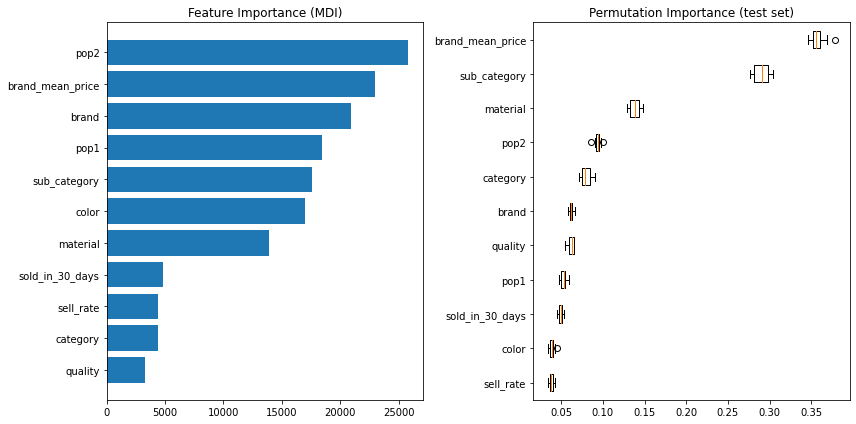

In [130]:
from sklearn.inspection import permutation_importance

feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_train.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')

result = permutation_importance(model, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(X_train.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

# Conclusion 

in order to recommend an **acceptable range price** I would use this model to predict the price based on the different features and then create the range by adding the error to the mix